# CDF comparison of ERA5 and CMIP model outputs
by sorting the output in order of decreasing discharge, we can easily make a cummalative distribution. By taking the difference of these functions we derive a (very simple) bias correction function that can later be used to bias-correct the future model output when forced with CMIP projections.

In [1]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import json

# Niceties
from rich import print

In [2]:
# General eWaterCycle
import ewatercycle
import ewatercycle.forcing

In [3]:
# For MEV
from scipy.stats import genextreme, gumbel_r, weibull_min

In [4]:
# Load settings
# Read from the JSON file
with open("settings.json", "r") as json_file:
    settings = json.load(json_file)

In [5]:
print(settings)

{
    'caravan_id': 'hysets_01371500',
    'calibration_start_date': '1997-08-01T00:00:00Z',
    'calibration_end_date': '2007-07-31T00:00:00Z',
    'validation_start_date': '2007-08-01T00:00:00Z',
    'validation_end_date': '2010-07-31T00:00:00Z',
    'future_start_date': '2027-08-01T00:00:00Z',
    'future_end_date': '2047-08-31T00:00:00Z',
    'CMIP_info': {
        'dataset': ['MPI-ESM1-2-HR'],
        'ensembles': ['r1i1p1f1'],
        'experiments': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
        'project': 'CMIP6',
        'frequency': 'day',
        'grid': 'gn',
        'variables': ['pr', 'tas', 'rsds']
    },
    'base_path': '/home/rhut/ewatercycleClimateImpact/HBV',
    'path_caravan': '/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/caravan',
    'path_ERA5': '/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/ERA5',
    'path_CMIP6': '/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/CMIP6',
    'path_shape': '/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/caravan/hysets_01371500.shp'
}

In [6]:
# Open the output of the historic model and CMIP runs
xr_historic = xr.open_dataset(Path(settings['base_path']) / (settings['caravan_id'] + '_historic_output.nc'))

In [7]:
print(xr_historic)

<xarray.Dataset> Size: 133kB
Dimensions:                             (time: 4748)
Coordinates: (12/18)
  * time                                (time) datetime64[ns] 38kB 1997-08-01...
    basin_id                            |S64 64B ...
    timezone                            |S64 64B ...
    name                                |S64 64B ...
    country                             |S64 64B ...
    lat                                 float64 8B ...
    ...                                  ...
    moisture_index                      float64 8B ...
    seasonality                         float64 8B ...
    high_prec_freq                      float64 8B ...
    high_prec_dur                       float64 8B ...
    low_prec_freq                       float64 8B ...
    low_prec_dur                        float64 8B ...
Data variables:
    modelled discharge, forcing: ERA5   (time) float64 38kB ...
    modelled discharge, forcing: CMIP6  (time) float64 38kB ...
    observed Q Caravan                  (time) float32 19kB ...
Attributes:
    units:    mm/d

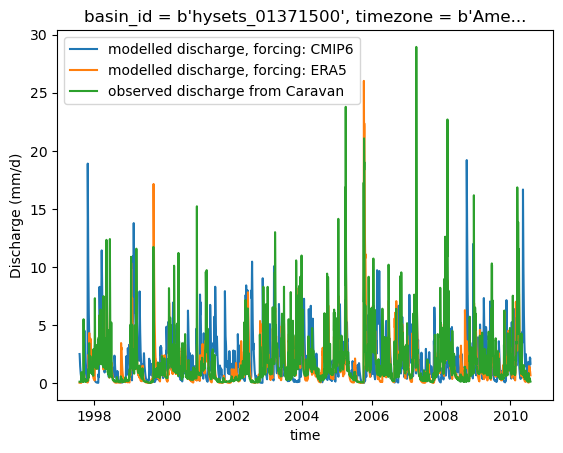

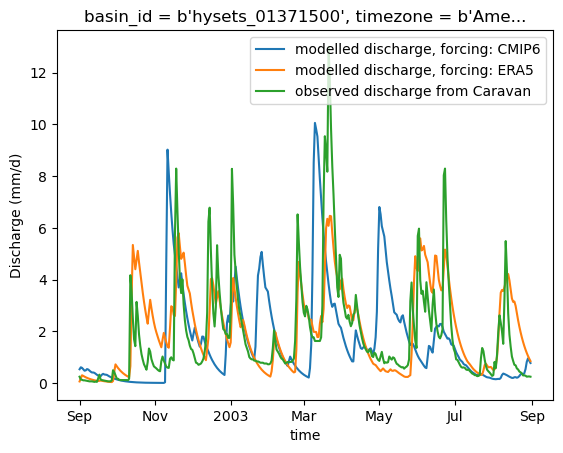

In [8]:
def plot_hydrograph(data_array):
    plt.figure()
    data_array['modelled discharge, forcing: CMIP6'].plot(label = 'modelled discharge, forcing: CMIP6')
    data_array['modelled discharge, forcing: ERA5'].plot(label = 'modelled discharge, forcing: ERA5')
    data_array['observed Q Caravan'].plot(label = 'observed discharge from Caravan')
    plt.ylabel("Discharge (mm/d)")
    plt.legend()


xr_one_year = xr_historic.sel(time=slice('2002-09-01', '2003-08-31'))

plot_hydrograph(xr_historic)
plot_hydrograph(xr_one_year)

In [9]:
def plot_cdf(ds):
    """
    plot cdf for all data variables 

    Parameters:
    - ds: xarray.Dataset
                       defaults to True
    Returns:
    - nothing
    """
    # 1. Drop time points with missing data in any variable
    valid_ds = ds.dropna(dim="time")
    
    # 2. Sort each variable from highest to lowest
    sorted_vars = {
        name: np.sort(valid_ds[name].values)[::-1]  # sort descending
        for name in valid_ds.data_vars
    }
    
    # 3. Create new indices
    n = len(valid_ds.time)
    cdf_index = np.linspace(0, 1, n)
    return_period_days = np.linspace(n, 1, n)
    return_period_years = return_period_days / 365.25  # convert to years
    
    # 4. Construct new xarray Dataset for CDFs
    cdf_ds = xr.Dataset(
        {
            name: ("cdf", sorted_vars[name])
            for name in sorted_vars
        },
        coords={
            "cdf": cdf_index,
            "return_period": ("cdf", return_period_years)
        }
    )
    
    # 5. Plot the CDFs
    plt.figure(figsize=(10, 6))
    for name in cdf_ds.data_vars:
        plt.plot(cdf_ds.cdf, cdf_ds[name], label=name)
    
    plt.xlabel("Cumulative Probability")
    plt.ylabel("Discharge (mm/d)")
    plt.title("Empirical CDFs of Discharge Data")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # 6. Plot the Return Period curves (log-log scale)
    plt.figure(figsize=(10, 6))
    for name in cdf_ds.data_vars:
        plt.plot(cdf_ds.return_period, cdf_ds[name], label=name)
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Return Period (years)")
    plt.ylabel("Discharge (mm/d)")
    plt.title("Return Period Plot of Discharge Data (Log-Log Scale)")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

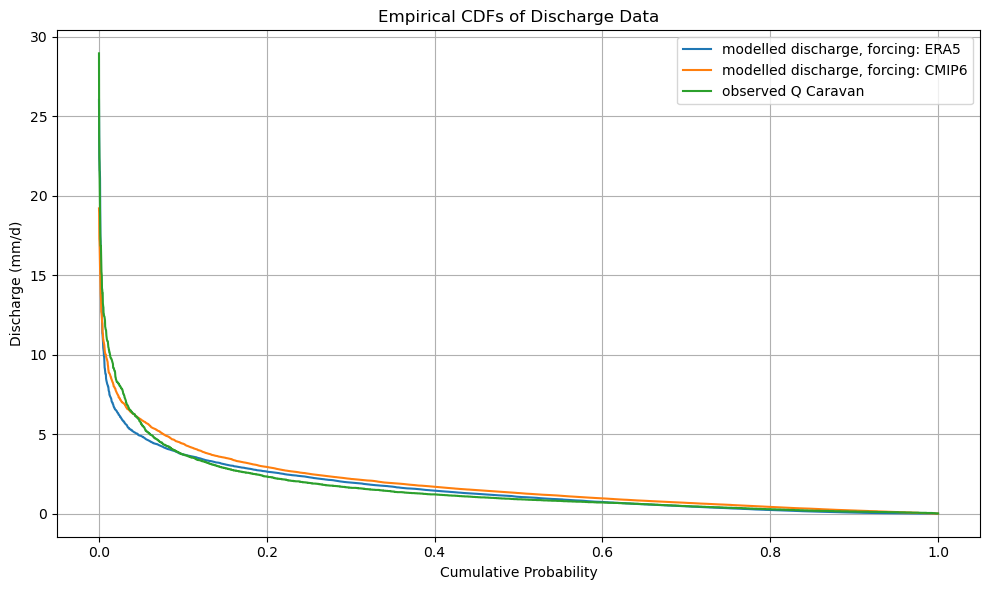

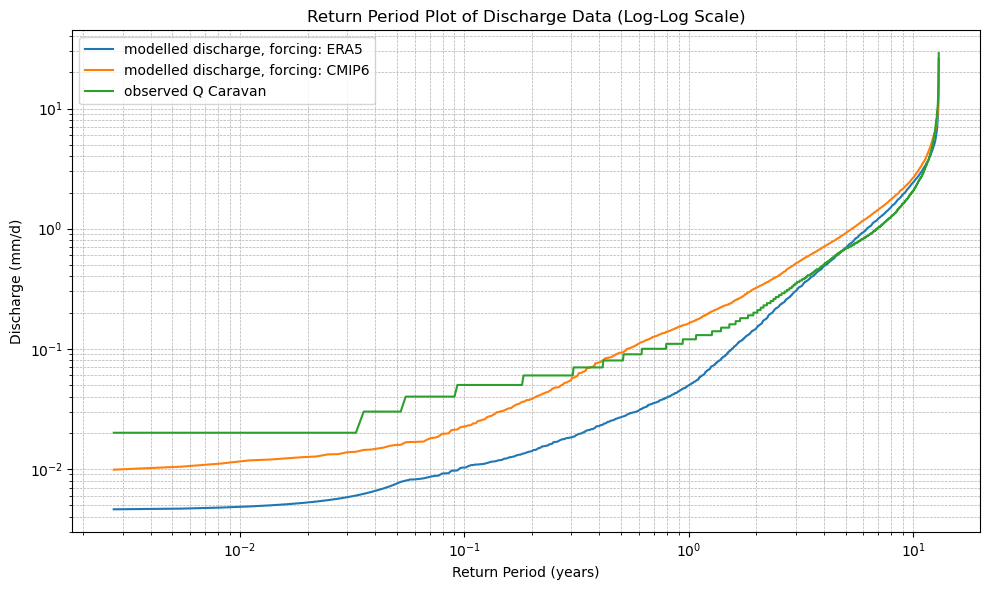

In [10]:
plot_cdf(xr_historic)

In [11]:
def calculate_mev(ds, dist_type='gev'):
    """
    Calculate MEV-based return periods for all data variables in an xarray.Dataset.

    Parameters:
    - ds: xarray.Dataset
    - dist_type: str, one of ['gev', 'gumbel', 'weibull']

    Returns:
    - xarray.Dataset with MEV return periods
    """
    # Step 1: Drop time points with missing data in any variable
    valid_ds = ds.dropna(dim="time", how="any")

    # Step 2: Extract daily values for each year
    years = np.unique(valid_ds['time.year'].values)
    mev_distributions = {}

    for var in ds.data_vars:
        annual_params = []
        for year in years:
            values = valid_ds[var].sel(time=str(year)).values
            if len(values) > 0:
                # Fit distribution based on dist_type
                if dist_type == 'gev':
                    params = genextreme.fit(values)
                    dist_func = genextreme
                elif dist_type == 'gumbel':
                    params = gumbel_r.fit(values)
                    dist_func = gumbel_r
                elif dist_type == 'weibull':
                    params = weibull_min.fit(values)
                    dist_func = weibull_min
                else:
                    raise ValueError("dist_type must be one of ['gev', 'gumbel', 'weibull']")
                annual_params.append(params)

        # Generate MEV by averaging annual distributions
        x_vals = np.linspace(np.min(valid_ds[var]), np.max(valid_ds[var]), 1000)
        cdfs = [dist_func.cdf(x_vals, *params) for params in annual_params]
        mean_cdf = np.mean(cdfs, axis=0)
        return_period = 1 / (1 - mean_cdf)

        mev_distributions[var] = (x_vals, return_period)

    # Step 3: Create MEV xarray Dataset
    mev_ds = xr.Dataset(
        {
            var: ("x", mev_distributions[var][1])
            for var in mev_distributions
        },
        coords={
            "x": list(mev_distributions.values())[0][0],
        },
        attrs=ds.attrs  # retain metadata
    )

    return mev_ds

def plot_mev(*mev_datasets, dist_type='gev', labels=None):
    """
    Plot MEV curves from one or more xarray.Dataset objects created by calculate_mev().

    Parameters:
    - mev_datasets: one or more xarray.Dataset objects
    - dist_type: str, name of the distribution used (for plot title)
    - labels: list of str, labels for each dataset
    """
    plt.figure(figsize=(10, 6))

    for i, mev_ds in enumerate(mev_datasets):
        prefix = f"{labels[i]} - " if labels else ""
        for var in mev_ds.data_vars:
            plt.plot(mev_ds[var].values, mev_ds['x'].values, label=f"{prefix}{var}")

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Return Period (years)")
    plt.ylabel("Discharge (mm/d)")
    plt.title(f"Metastatistical Extreme Value (MEV) Estimates - {dist_type.upper()} Fit")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


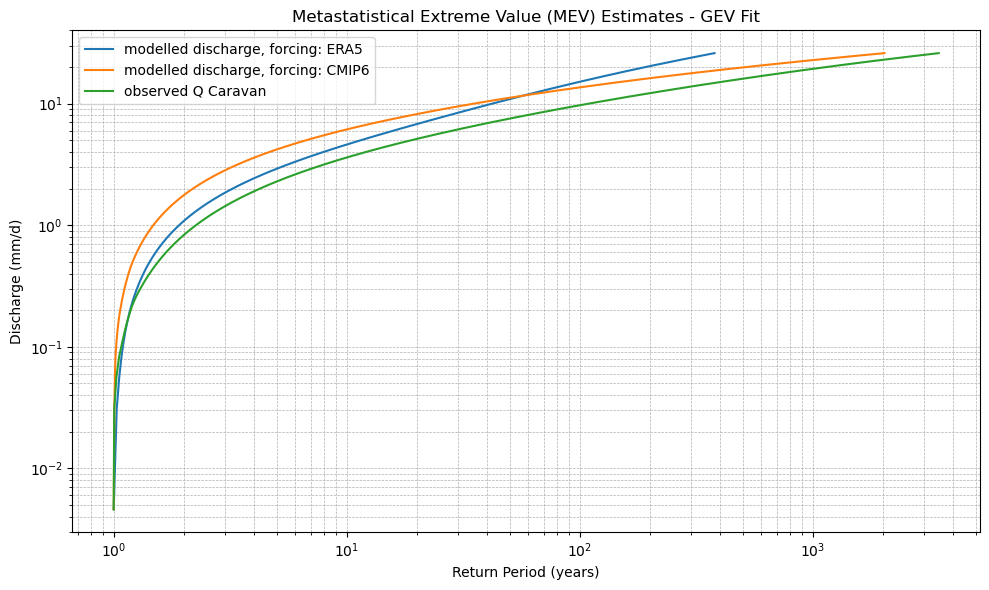

In [12]:
xr_mev_historic = calculate_mev(xr_historic,'weibull')
plot_mev(xr_mev_historic)

In [13]:
# Open the output of the historic model and CMIP runs
xr_future = xr.open_dataset(Path(settings['base_path']) / (settings['caravan_id'] + '_future_output.nc'))

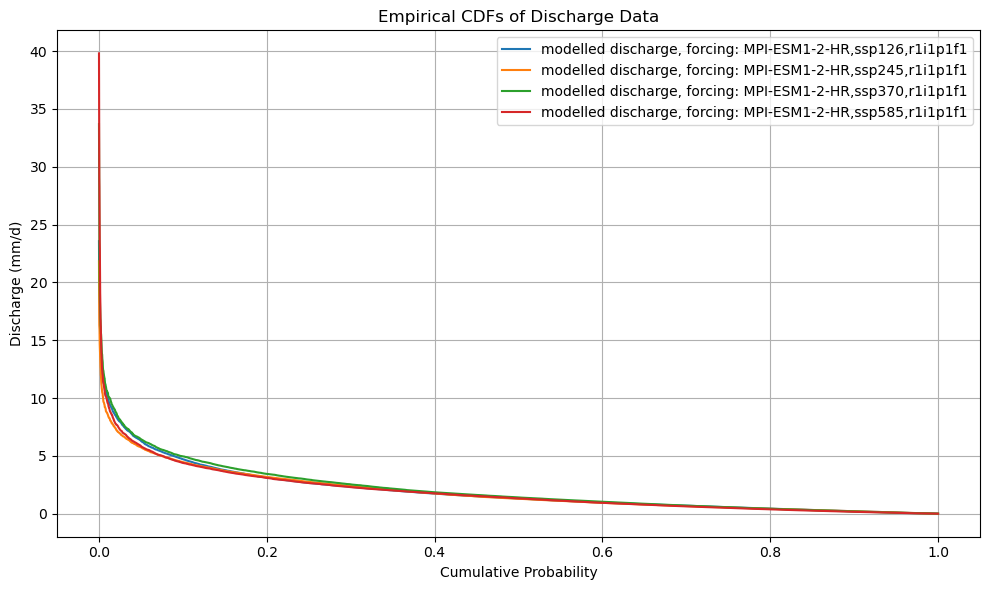

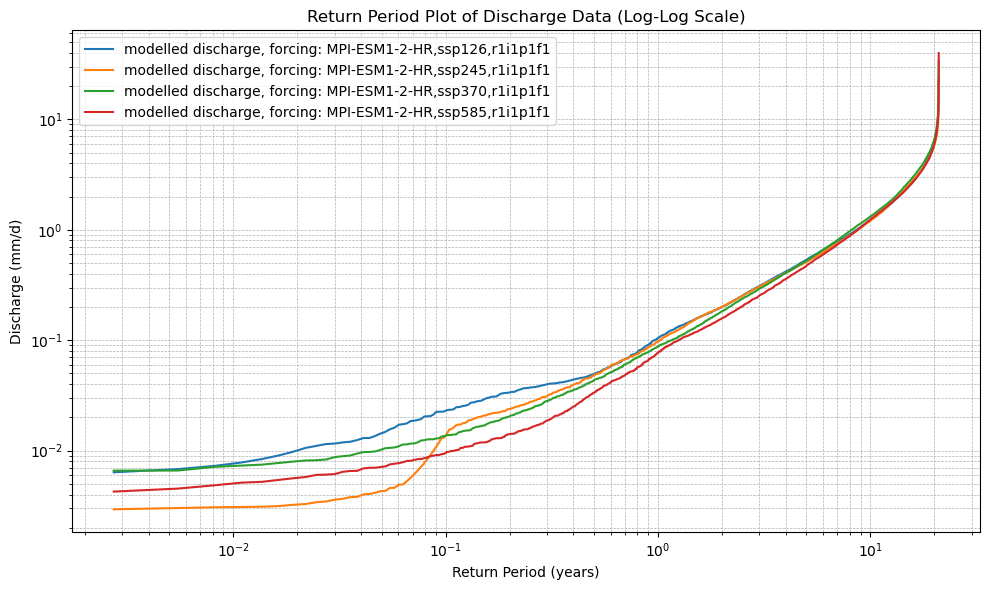

In [14]:
plot_cdf(xr_future)

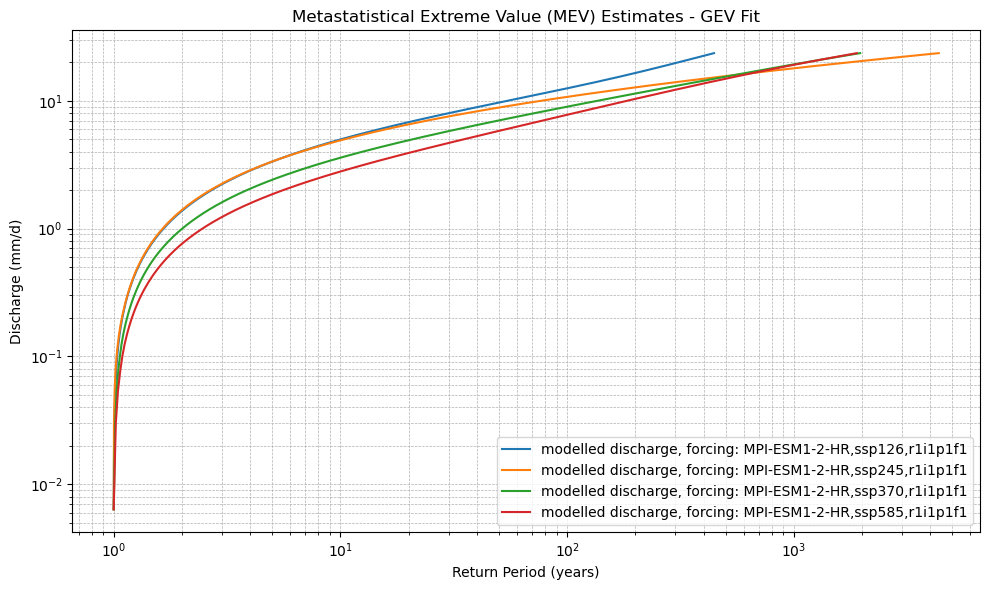

In [15]:
xr_mev_future = calculate_mev(xr_future,'weibull')
plot_mev(xr_mev_future)

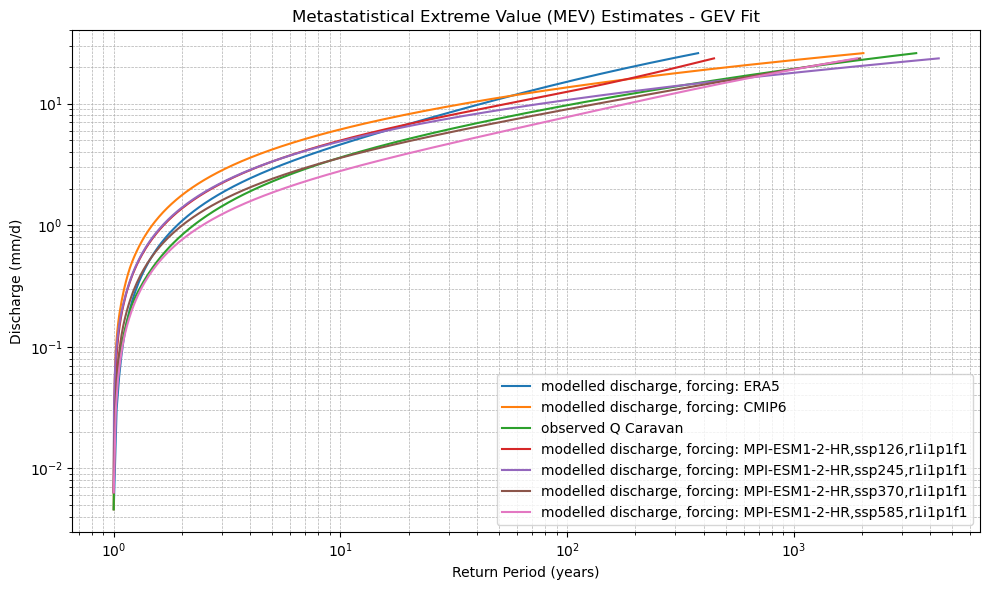

In [16]:
plot_mev(xr_mev_historic, xr_mev_future)